In [0]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [0]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
img, labels = mnist[0]
print(f'Image',img)
print('Label', labels)

Image tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.00

In [0]:
torch.min(img), torch.max(img)

(tensor(-1.), tensor(1.))

In [0]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0, 1)

Label: 5


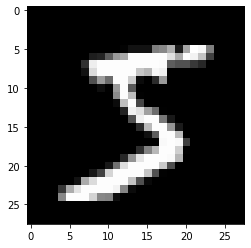

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img[0], cmap='gray')
print('Label:', labels)

In [0]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [0]:
data_loader

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 3, 4, 9, 6, 5, 3, 6, 7, 4, 7, 9, 7, 7, 5, 1, 8, 9, 9, 6, 1, 7, 1, 1,
        0, 5, 1, 9, 1, 7, 4, 1, 0, 4, 5, 6, 3, 9, 6, 7, 5, 0, 6, 1, 5, 0, 8, 5,
        4, 3, 8, 3, 8, 0, 3, 8, 6, 5, 4, 1, 3, 6, 0, 5, 2, 0, 1, 3, 6, 1, 6, 7,
        6, 6, 1, 8, 4, 8, 4, 3, 8, 7, 2, 1, 1, 9, 6, 9, 4, 4, 4, 1, 4, 1, 7, 3,
        8, 9, 7, 3])


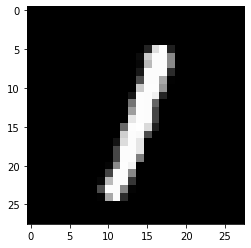

In [0]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [0]:
device = torch.device('cuda')

In [0]:
image_size = 784
hidden_size = 256

In [0]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [0]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [0]:
latent_size = 64

In [0]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [0]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

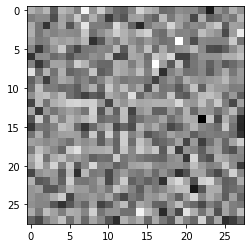

In [0]:
plt.imshow(gen_imgs[0], cmap='gray')

In [0]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [0]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [0]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [0]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

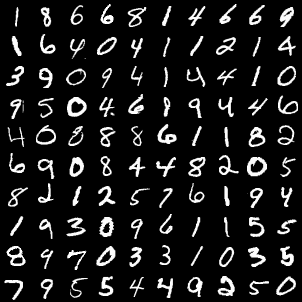

In [0]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


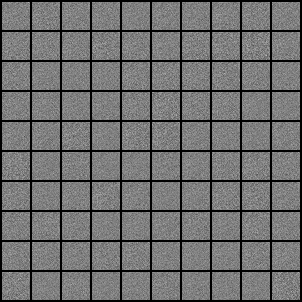

In [0]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


In [33]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0469, g_loss: 3.8511, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1053, g_loss: 6.0970, D(x): 0.95, D(G(z)): 0.02
Epoch [0/300], Step [600/600], d_loss: 0.0734, g_loss: 4.2144, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0479, g_loss: 5.3816, D(x): 0.99, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.1707, g_loss: 5.1744, D(x): 0.94, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.1274, g_loss: 5.0018, D(x): 0.97, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5582, g_loss: 3.3705, D(x): 0.80, D(G(z)): 0.07
Epoch [2/300], Step [400/600], d_loss: 0.4041, g_loss: 4.8057, D(x): 0.87, D(G(z)): 0.07
Epoch [2/300], Step [600/600], d_loss: 0.1273, g_loss: 6.0453, D(x): 0.93, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3576, g_loss: 4.0659, D(x): 0.90, D(G(z)): 0.16
Epoch [3/300], Step [400/6

In [0]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [36]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

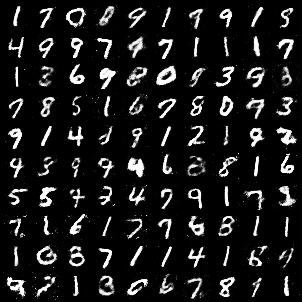

In [43]:
# from Ipython.display import Image
Image('samples/fake_images-0200.png')

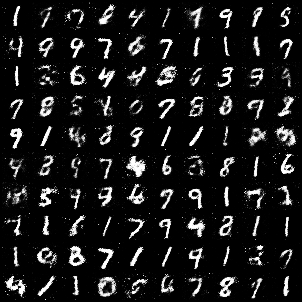

In [44]:
Image('samples/fake_images-0100.png')

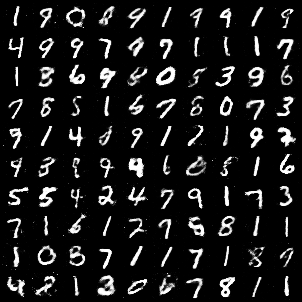

In [45]:
Image('samples/fake_images-0300.png')

In [39]:
! ls samples/

fake_images-0000.png  fake_images-0101.png  fake_images-0202.png
fake_images-0001.png  fake_images-0102.png  fake_images-0203.png
fake_images-0002.png  fake_images-0103.png  fake_images-0204.png
fake_images-0003.png  fake_images-0104.png  fake_images-0205.png
fake_images-0004.png  fake_images-0105.png  fake_images-0206.png
fake_images-0005.png  fake_images-0106.png  fake_images-0207.png
fake_images-0006.png  fake_images-0107.png  fake_images-0208.png
fake_images-0007.png  fake_images-0108.png  fake_images-0209.png
fake_images-0008.png  fake_images-0109.png  fake_images-0210.png
fake_images-0009.png  fake_images-0110.png  fake_images-0211.png
fake_images-0010.png  fake_images-0111.png  fake_images-0212.png
fake_images-0011.png  fake_images-0112.png  fake_images-0213.png
fake_images-0012.png  fake_images-0113.png  fake_images-0214.png
fake_images-0013.png  fake_images-0114.png  fake_images-0215.png
fake_images-0014.png  fake_images-0115.png  fake_images-0216.png
fake_images-0015.png  fak